In [1]:
import os
import errno

import numpy as np
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras import backend as K

from deepcell.utils.data_utils import make_training_data
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler
from deepcell.model_zoo import bn_feature_net_2D
from deepcell.model_zoo import bn_feature_net_skip_2D
from deepcell.training import train_model_conv
from deepcell.training import train_model_sample

Using TensorFlow backend.


## Load the Training Data

In [2]:
RESIZE = True
RESHAPE_SIZE = 512

# filepath constants 
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'
PREFIX = 'cells/ecoli/kc'
DATA_FILE = 'ecoli_kc'.format(K.image_data_format())

# Check for channels_first or channels_last
IS_CHANNELS_FIRST = K.image_data_format() == 'channels_first'

ROW_AXIS = 2 if IS_CHANNELS_FIRST else 1
COL_AXIS = 3 if IS_CHANNELS_FIRST else 2
CHANNEL_AXIS = 1 if IS_CHANNELS_FIRST else 3

# create these directories if they do not exist
for d in (NPZ_DIR, MODEL_DIR, RESULTS_DIR):
    try:
        os.makedirs(os.path.join(d, PREFIX))
        print('Created new directory:', os.path.join(d, PREFIX))
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

In [3]:
# Create the training data
make_training_data(
    dimensionality=2,
    direc_name=os.path.join(DATA_DIR, PREFIX),
    file_name_save=os.path.join(NPZ_DIR, PREFIX, DATA_FILE),
    training_direcs=['set1', 'set2'],
    channel_names=['phase'],
    raw_image_direc='processed',
    annotation_direc='annotated',
    reshape_size=RESHAPE_SIZE if RESIZE else None)

if os.path.isfile(os.path.join(NPZ_DIR, PREFIX, DATA_FILE) + '.npz'):
    print('Data Saved to', os.path.join(NPZ_DIR, PREFIX, DATA_FILE) + '.npz')
else:
    raise Exception('Uh Oh!  Your data file did not save properly :(')

Reshaped feature data from (2, 1002, 1004, 1) to (8, 512, 512, 1)
Reshaped training data from (2, 1002, 1004, 1) to (8, 512, 512, 1)
Data Saved to /data/npz_data/cells/ecoli/kc/ecoli_kc.npz


## Fully Convolutional Training

In [4]:
# Load the training data from NPZ into a numpy array
training_data = np.load(os.path.join(NPZ_DIR, PREFIX, DATA_FILE + '.npz'))

X, y = training_data['X'], training_data['y']
print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

# save the size of the input data for input_shape model parameter
size = (RESHAPE_SIZE, RESHAPE_SIZE) if RESIZE else X.shape[ROW_AXIS:COL_AXIS + 1]
if IS_CHANNELS_FIRST:
    input_shape = (X.shape[CHANNEL_AXIS], size[0], size[1])
else:
    input_shape = (size[0], size[1], X.shape[CHANNEL_AXIS])
    
# Set up other training parameters
n_epoch = 32
batch_size = 1
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=0.99)

X.shape: (8, 512, 512, 1)
y.shape: (8, 512, 512, 1)


In [5]:
# Instantiate the model
conv_model = bn_feature_net_skip_2D(
    receptive_field=61,
    n_skips=2,
    n_features=3,  # (cell edge, cell interior, background)
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=input_shape,
    multires=False,
    last_only=False)

# Train the model
train_model_conv(
    model=conv_model,
    dataset=DATA_FILE,
    expt='conv',
    transform='deepcell',
    dilation_radius=1,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (7, 512, 512, 1)
y_train shape: (7, 512, 512, 1)
X_test shape: (1, 512, 512, 1)
y_test shape: (1, 512, 512, 1)
Output Shape: (None, 512, 512, 3)
Number of Classes: 3
Epoch 1/32
6/7 [========================>.....] - ETA: 1s - loss: 3.0919 - model_1_loss: 1.0113 - model_2_loss: 1.0298 - model_3_loss: 1.0298 - model_1_acc: 0.3187 - model_2_acc: 0.2929 - model_3_acc: 0.3288
Epoch 00001: val_loss improved from inf to 3.80847, saving model to /data/models/cells/ecoli/kc/2018-08-31_ecoli_kc_conv.h5
7/7 [==============================] - 10s 1s/step - loss: 2.9960 - model_1_loss: 0.9817 - model_2_loss: 0.9973 - model_3_loss: 0.9960 - model_1_acc: 0.3309 - model_2_acc: 0.3176 - model_3_acc: 0.3503 - val_loss: 3.8085 - val_model_1_loss: 1.1397 - val_model_2_loss: 1.4823 - val_model_3_loss: 1.1654 - val_model_1_acc: 0.6361 - val_model_2_acc: 0.7745 - val_model_3_acc: 0.7659
Epoch 2/32
6/7 [========================>.....] - ETA: 0s - loss: 2.2568 - model_1_loss: 0.7753 - model_2_lo

Epoch 13/32
6/7 [========================>.....] - ETA: 0s - loss: 1.0597 - model_1_loss: 0.3468 - model_2_loss: 0.3616 - model_3_loss: 0.3303 - model_1_acc: 0.7958 - model_2_acc: 0.7932 - model_3_acc: 0.7986
Epoch 00013: val_loss improved from 1.82778 to 1.75321, saving model to /data/models/cells/ecoli/kc/2018-08-31_ecoli_kc_conv.h5
7/7 [==============================] - 4s 502ms/step - loss: 1.1019 - model_1_loss: 0.3623 - model_2_loss: 0.3754 - model_3_loss: 0.3431 - model_1_acc: 0.8031 - model_2_acc: 0.8005 - model_3_acc: 0.8074 - val_loss: 1.7532 - val_model_1_loss: 0.5798 - val_model_2_loss: 0.5220 - val_model_3_loss: 0.6303 - val_model_1_acc: 0.8977 - val_model_2_acc: 0.9108 - val_model_3_acc: 0.8966
Epoch 14/32
6/7 [========================>.....] - ETA: 0s - loss: 1.0980 - model_1_loss: 0.3379 - model_2_loss: 0.3903 - model_3_loss: 0.3487 - model_1_acc: 0.7970 - model_2_acc: 0.7936 - model_3_acc: 0.7959
Epoch 00014: val_loss improved from 1.75321 to 1.62227, saving model to /

6/7 [========================>.....] - ETA: 0s - loss: 1.0562 - model_1_loss: 0.3589 - model_2_loss: 0.3111 - model_3_loss: 0.3651 - model_1_acc: 0.8218 - model_2_acc: 0.8291 - model_3_acc: 0.8176
Epoch 00025: val_loss did not improve
7/7 [==============================] - 3s 456ms/step - loss: 1.0460 - model_1_loss: 0.3575 - model_2_loss: 0.3102 - model_3_loss: 0.3572 - model_1_acc: 0.8329 - model_2_acc: 0.8402 - model_3_acc: 0.8283 - val_loss: 1.2548 - val_model_1_loss: 0.4357 - val_model_2_loss: 0.3636 - val_model_3_loss: 0.4343 - val_model_1_acc: 0.9176 - val_model_2_acc: 0.9229 - val_model_3_acc: 0.9167
Epoch 26/32
6/7 [========================>.....] - ETA: 0s - loss: 0.8950 - model_1_loss: 0.2920 - model_2_loss: 0.2773 - model_3_loss: 0.3046 - model_1_acc: 0.7826 - model_2_acc: 0.7832 - model_3_acc: 0.7806
Epoch 00026: val_loss did not improve
7/7 [==============================] - 3s 455ms/step - loss: 0.9148 - model_1_loss: 0.2993 - model_2_loss: 0.2836 - model_3_loss: 0.3107 

In [6]:
# With the trained model, make predictions on testing data
training_data_file = os.path.join(NPZ_DIR, PREFIX, DATA_FILE + '.npz')

train_dict, test_dict = get_data(training_data_file, mode='conv', seed=21)

X_test, y_test = test_dict['X'], test_dict['y']

test_images = conv_model.predict(X_test)[-1]

print('model output shape:', test_images.shape)

model output shape: (1, 512, 512, 3)


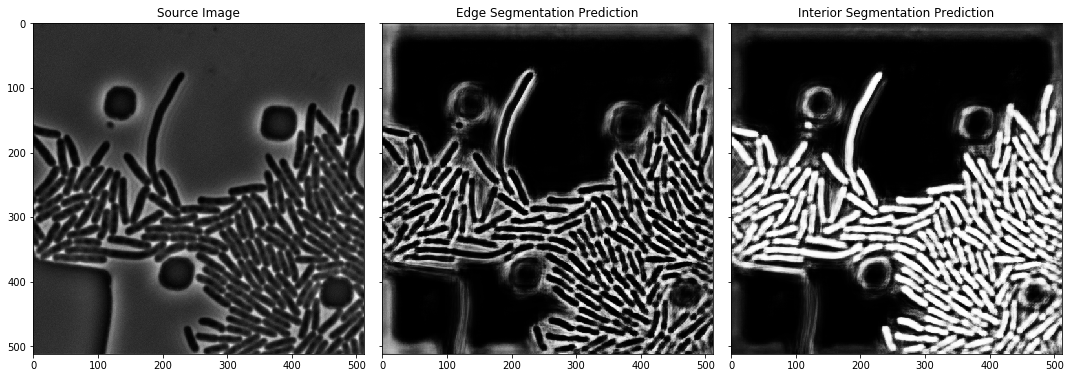

In [7]:
# Plot the results
import matplotlib.pyplot as plt

index = 0

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, :, :, 0], cmap='gray')
ax[0].set_title('Source Image')

ax[1].imshow(test_images[index, :, :, 0], cmap='gray')
ax[1].set_title('Edge Segmentation Prediction')

ax[2].imshow(test_images[index, :, :, 1], cmap='gray')
ax[2].set_title('Interior Segmentation Prediction')

fig.tight_layout()
plt.show()

## Sample Based Training

In [8]:
# Load the training data from NPZ into a numpy array
training_data = np.load(os.path.join(NPZ_DIR, PREFIX, DATA_FILE + '.npz'))

X, y = training_data['X'], training_data['y']
print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

# Sample window dimensions
WIN_X = 30
WIN_Y = 30

# Set up training parameters
n_epoch = 3
batch_size = 64
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=.99)

X.shape: (8, 512, 512, 1)
y.shape: (8, 512, 512, 1)


In [9]:
# Instantiate the model
sample_model = bn_feature_net_2D(
    receptive_field=WIN_X + WIN_Y + 1,
    n_features=3,
    reg=1e-5,
    norm_method='median',
    n_channels=X.shape[CHANNEL_AXIS])

# Train the model
train_model_sample(
    model=sample_model,
    dataset=DATA_FILE,
    expt='sample',
    transform='deepcell',
    dilation_radius=1,
    optimizer=optimizer,
    batch_size=batch_size,
    window_size=(WIN_X, WIN_Y),
    balance_classes=True,
    max_class_samples=None,
    n_epoch=n_epoch,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (7, 512, 512, 1)
y_train shape: (7, 512, 512, 1)
X_test shape: (1, 512, 512, 1)
y_test shape: (1, 512, 512, 1)
Output Shape: (None, 3)
Number of Classes: 3
Epoch 1/3
6609/6611 [============================>.] - ETA: 0s - loss: 0.3621 - acc: 0.8901
Epoch 00001: val_loss improved from inf to 0.28208, saving model to /data/models/cells/ecoli/kc/2018-08-31_ecoli_kc_sample.h5
6611/6611 [==============================] - 222s 34ms/step - loss: 0.3621 - acc: 0.8901 - val_loss: 0.2821 - val_acc: 0.9102
Epoch 2/3
6610/6611 [============================>.] - ETA: 0s - loss: 0.3454 - acc: 0.8960
Epoch 00002: val_loss improved from 0.28208 to 0.28115, saving model to /data/models/cells/ecoli/kc/2018-08-31_ecoli_kc_sample.h5
6611/6611 [==============================] - 216s 33ms/step - loss: 0.3453 - acc: 0.8960 - val_loss: 0.2812 - val_acc: 0.9037
Epoch 3/3
6609/6611 [============================>.] - ETA: 0s - loss: 0.3399 - acc: 0.8974
Epoch 00003: val_loss improved from 0.28115 t

In [10]:
# With the trained models, make predictions on testing data
training_data_file = os.path.join(NPZ_DIR, PREFIX, DATA_FILE + '.npz')

train_dict, test_dict = get_data(training_data_file, mode='sample', seed=21)

X_test, y_test = test_dict['X'], test_dict['y']

# Re-initializing dilated models for sample-mode predictions
sample_weights_file = '2018-08-31_ecoli_kc_sample.h5'
sample_weights_file = os.path.join(MODEL_DIR, PREFIX, sample_weights_file)

run_sample_model = bn_feature_net_2D(
    receptive_field=WIN_X + WIN_Y + 1,
    n_features=3,
    norm_method='median',
    dilated=True,
    input_shape=X_test.shape[1:])
run_sample_model.load_weights(sample_weights_file)

test_images = run_sample_model.predict(X_test)

print('model output shape:', test_images.shape)

model output shape: (1, 512, 512, 3)


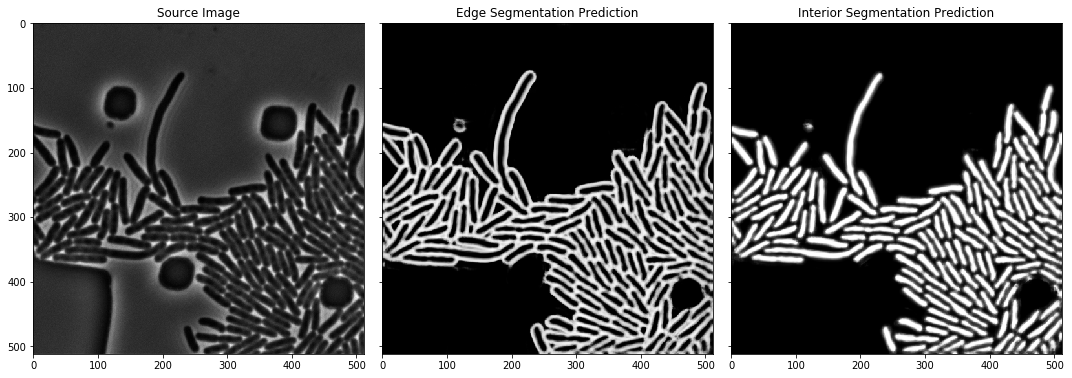

In [11]:
# Plot the results
import matplotlib.pyplot as plt

index = 0

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, :, :, 0], cmap='gray')
ax[0].set_title('Source Image')

ax[1].imshow(test_images[index, :, :, 0], cmap='gray')
ax[1].set_title('Edge Segmentation Prediction')

ax[2].imshow(test_images[index, :, :, 1], cmap='gray')
ax[2].set_title('Interior Segmentation Prediction')

fig.tight_layout()
plt.show()